# CMPUT 328 — Logistic Regression Lab Assignment

**Total Weight:** 5% of course grade  
**Part 1 (Lab):** 2%  
**Part 2 (Take-home):** 3%  
**Deadline:** One week from lab date  

**Tools:** Google Colab + Gemini (AI assistance allowed, but cite and document).

---

## 🔧 Setup

In [ ]:
# Install PyTorch + torchvision (if needed)
# !pip install -q torch torchvision
%matplotlib inline

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 📦 Data Preparation

In [ ]:
# Transform: normalize MNIST images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Download MNIST
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Split into train (50k) and validation (10k)
train_size = 50_000
val_size = len(train_ds) - train_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Part 1 — In-Lab (2%)

Implement and train Logistic Regression on MNIST.  
Complete the following steps **during the lab (3 hours)**.

### 1. Baseline Logistic Regression

In [ ]:
# TODO: Define Logistic Regression model using nn.Linear(784, 10).
class LogisticRegression(nn.Module):
    def __init__(self, in_dim=28*28, out_dim=10):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))

model = LogisticRegression().to(device)
print(model)

LogisticRegression(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)


### 2. Training Loop (SGD + CrossEntropyLoss)

In [ ]:
# TODO: Write training loop
def l1_reg(model):
  l1_loss = 0.0
  for params in model.parameters():
    l1_loss+= torch.sum(torch.abs(params))
  return l1_loss

def train(optim= None, regularization=None,model=model, l1_lambda=None, training_size = 1, confusion =None,flip=None):


  LEARNING_RATE = 0.001
  num_epochs = 30


  val_acc = []
  training_acc = []


  val_loss=[]
  training_loss=[]


  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)


  if optim=="adam":
    optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

  if regularization=='l2':
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE,weight_decay=1e-3)

  ##########train#############


  for epoch in range(num_epochs):
    batch_loss = 0.0
    correct = 0
    total = 0
    for id,(X_train,y_train) in enumerate(train_loader):

      # every id% 1/training_size is passed rest are skipped, eg , 10% dataset = 0.1 hence every 10th item will be kept rest will be skipped
      if id%(int(1/training_size))==0:
        pass
      else:
        continue
      if flip =='flip':

        n = len(y_train)
        n_flip = int(0.1 * n)
        num_classes = 10
        flip_idx = torch.randperm(n)[:n_flip]
        y_train[flip_idx] = torch.randint(0, num_classes, (n_flip,))    #GPT rompt if flip =='flip': y_train[:10]=torch.from_numpy(np.random.randint(0,10, size=10)), is this changing first 10 elements of tensor to random numbers?

      X_train = X_train.to(device)
      y_train = y_train.to(device)  #loading tensors to cuda
      optimizer.zero_grad() #refreshing weighst to zero
      y_pred = model(X_train)

      loss = criterion(y_pred, y_train) #loss calc


      if regularization=='l1':
        loss+=(l1_lambda*l1_reg(model))   # if L1 regularizrion is passed


      loss.backward() #back prop
      optimizer.step()
      batch_loss+=loss.item()

      pred = torch.argmax(y_pred, dim=1)
      correct += pred.eq(y_train).sum().item()
      total += y_train.size(0)

    training_loss.append(round(batch_loss/len(train_loader),2))
    print(f"epoch {epoch+1}, loss {batch_loss/len(train_loader)}")
    training_acc.append(round(100. * (correct / total),2))
    ##########validate#############

    model.eval()
    validation_loss = 0.0
    correct = 0
    with torch.no_grad():
      for X_val,y_val in val_loader:
        X_val= X_val.to(device)
        y_val= y_val.to(device)
        y_pred = model(X_val)
        loss= criterion(y_pred,y_val)
        validation_loss+=loss.item()
        pred = torch.argmax(y_pred,dim=1)
        correct+=pred.eq(y_val).sum().item()
      validation_loss/=len(val_loader)
      print(f"nValidation set: Avg. loss: {validation_loss:.4f}, Accuracy: {correct}/{len(val_ds)} ({100. * (correct / len(val_ds)):.0f}%)\n")
      val_loss.append(round(validation_loss,2))
      val_acc.append(round(100. * (correct / len(val_ds)),2))

  ##########test#############
  model.eval()
  test_loss=0.0
  correct=0
  ret_y_test = []
  ret_y_pred = []

  with torch.no_grad():
    for X_test, y_test in test_loader:
      X_test = X_test.to(device)
      y_test= y_test.to(device)

      ret_y_test.append(y_test.cpu())

      y_pred= model(X_test)
      loss = criterion( y_pred,y_test)
      test_loss+= loss.item()
      pred =torch.argmax(y_pred,dim=1)

      ret_y_pred.append(pred.cpu())

      correct+= pred.eq(y_test).sum().item()
  test_loss /= len(test_loader)
  ret_y_pred=torch.cat(ret_y_pred)
  ret_y_test = torch.cat(ret_y_test)
  print(f"\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_ds)} ({100. * (correct / len(test_ds)):.0f}%)\n")


  if confusion==None:
    return num_epochs,training_acc,val_acc,training_loss,val_loss
  else:
    return ret_y_pred,ret_y_test

In [ ]:
# TODO: Re-run training with L2 (via weight_decay).
# TODO: Implement manual L1 penalty and compare results.

###########L2#################


print("########################## SGD + CROSS ENTROPY ############################")
num_epochs,base_training_acc,base_val_acc,base_training_loss,base_val_loss = train()
#print(num_epochs,training_acc,val_acc,training_loss,val_loss)

########################## SGD + CROSS ENTROPY ############################
epoch 1, loss 1.3574099243449433
nValidation set: Avg. loss: 0.8690, Accuracy: 8128/10000 (81%)

epoch 2, loss 0.7498435363592699
nValidation set: Avg. loss: 0.6460, Accuracy: 8503/10000 (85%)

epoch 3, loss 0.6087546525403972
nValidation set: Avg. loss: 0.5564, Accuracy: 8636/10000 (86%)

epoch 4, loss 0.5416052272100278
nValidation set: Avg. loss: 0.5068, Accuracy: 8710/10000 (87%)

epoch 5, loss 0.5009043688511909
nValidation set: Avg. loss: 0.4745, Accuracy: 8772/10000 (88%)

epoch 6, loss 0.4730372042454722
nValidation set: Avg. loss: 0.4515, Accuracy: 8811/10000 (88%)

epoch 7, loss 0.452785652159425
nValidation set: Avg. loss: 0.4341, Accuracy: 8830/10000 (88%)

epoch 8, loss 0.43653328766298416
nValidation set: Avg. loss: 0.4203, Accuracy: 8867/10000 (89%)

epoch 9, loss 0.42372344018858105
nValidation set: Avg. loss: 0.4091, Accuracy: 8892/10000 (89%)

epoch 10, loss 0.41348444622800784
nValidation set

### 3. Regularization (L2, L1)

In [ ]:
print("########################## SGD + CROSS ENTROPY + L2 REGULARIZATION ############################")
l2_model = LogisticRegression().to(device)
print(l2_model)
num_epochs,l2_training_acc,l2_val_acc,l2_training_loss,l2_val_loss= train(None,'l2',l2_model)
#print(num_epochs,training_acc,val_acc,training_loss,val_loss)


########################## SGD + CROSS ENTROPY + L2 REGULARIZATION ############################
LogisticRegression(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)
epoch 1, loss 1.3590017695865972
nValidation set: Avg. loss: 0.8727, Accuracy: 8164/10000 (82%)

epoch 2, loss 0.7498817625253097
nValidation set: Avg. loss: 0.6464, Accuracy: 8522/10000 (85%)

epoch 3, loss 0.6073347540462718
nValidation set: Avg. loss: 0.5562, Accuracy: 8655/10000 (87%)

epoch 4, loss 0.5399538206932185
nValidation set: Avg. loss: 0.5066, Accuracy: 8725/10000 (87%)

epoch 5, loss 0.49947524878679944
nValidation set: Avg. loss: 0.4744, Accuracy: 8779/10000 (88%)

epoch 6, loss 0.4718336267087161
nValidation set: Avg. loss: 0.4518, Accuracy: 8803/10000 (88%)

epoch 7, loss 0.45144993714664294
nValidation set: Avg. loss: 0.4344, Accuracy: 8833/10000 (88%)

epoch 8, loss 0.43577196797751405
nValidation set: Avg. loss: 0.4208, Accuracy: 8860/10000 (89%)

epoch 9, loss 0.4232493692346851
nValidatio

In [ ]:
print("########################## SGD + CROSS ENTROPY + L1 REGULARIZATION ############################")

LAMBDA = 1e-5
l1_model = LogisticRegression().to(device)
print(l1_model)
num_epochs,l1_training_acc,l1_val_acc,l1_training_loss,l1_val_loss=train(None,'l1',l1_model,LAMBDA)
#print(num_epochs,training_acc,val_acc,training_loss,val_loss)

########################## SGD + CROSS ENTROPY + L1 REGULARIZATION ############################
LogisticRegression(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)
epoch 1, loss 1.3417253524751005
nValidation set: Avg. loss: 0.8669, Accuracy: 8165/10000 (82%)

epoch 2, loss 0.7477226739039506
nValidation set: Avg. loss: 0.6457, Accuracy: 8511/10000 (85%)

epoch 3, loss 0.6088263438943097
nValidation set: Avg. loss: 0.5572, Accuracy: 8633/10000 (86%)

epoch 4, loss 0.5423005120376186
nValidation set: Avg. loss: 0.5078, Accuracy: 8713/10000 (87%)

epoch 5, loss 0.5020609353966725
nValidation set: Avg. loss: 0.4756, Accuracy: 8754/10000 (88%)

epoch 6, loss 0.4742862986176825
nValidation set: Avg. loss: 0.4527, Accuracy: 8795/10000 (88%)

epoch 7, loss 0.4542062159084603
nValidation set: Avg. loss: 0.4354, Accuracy: 8834/10000 (88%)

epoch 8, loss 0.4382918486967111
nValidation set: Avg. loss: 0.4218, Accuracy: 8863/10000 (89%)

epoch 9, loss 0.4256496975184097
nValidation s

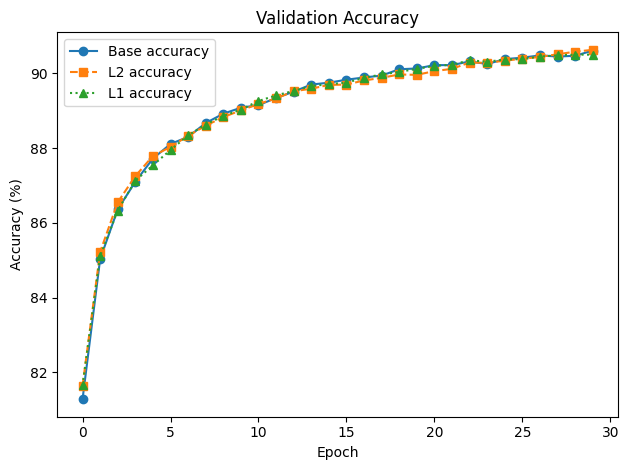

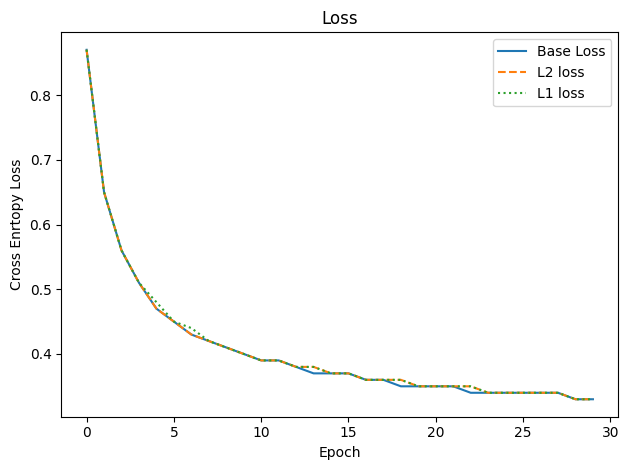

In [ ]:
#plot validation and loss

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
epochs = np.arange(len(base_training_acc))
plt.plot(epochs, base_val_acc, label="Base accuracy", linestyle="-", marker='o')
plt.plot(epochs, l2_val_acc, label="L2 accuracy", linestyle="--",marker='s')
plt.plot(epochs, l1_val_acc, label="L1 accuracy", linestyle=":",marker='^')
plt.tight_layout()
plt.legend()
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Cross Enrtopy Loss")
plt.title("Loss")
plt.plot(epochs, base_val_loss, label="Base Loss",linestyle="-" )
plt.plot(epochs, l2_val_loss, label="L2 loss",linestyle="--")
plt.plot(epochs, l1_val_loss, label= "L1 loss",linestyle=":")
plt.tight_layout()
plt.legend()
plt.show()



### 4. Optimizer Swap

In [ ]:
# TODO: Replace SGD with Adam optimizer and compare convergence speed.
print('####################### ADAM ###########################')
adam_model = LogisticRegression().to(device)
num_epochs,adam_training_acc,adam_val_acc,adam_training_loss,adam_val_loss=train('adam',None,adam_model)
#print(num_epochs,training_acc,val_acc,training_loss,val_loss)

####################### ADAM ###########################
epoch 1, loss 0.46569952490689503
nValidation set: Avg. loss: 0.3191, Accuracy: 9099/10000 (91%)

epoch 2, loss 0.306775029777261
nValidation set: Avg. loss: 0.2940, Accuracy: 9169/10000 (92%)

epoch 3, loss 0.28805572640560473
nValidation set: Avg. loss: 0.2858, Accuracy: 9195/10000 (92%)

epoch 4, loss 0.2783459227560731
nValidation set: Avg. loss: 0.2828, Accuracy: 9210/10000 (92%)

epoch 5, loss 0.27213031093559
nValidation set: Avg. loss: 0.2859, Accuracy: 9209/10000 (92%)

epoch 6, loss 0.2677743626410699
nValidation set: Avg. loss: 0.2858, Accuracy: 9199/10000 (92%)

epoch 7, loss 0.26370409313979964
nValidation set: Avg. loss: 0.2916, Accuracy: 9191/10000 (92%)

epoch 8, loss 0.2608915236028259
nValidation set: Avg. loss: 0.2791, Accuracy: 9232/10000 (92%)

epoch 9, loss 0.25883728454408744
nValidation set: Avg. loss: 0.2894, Accuracy: 9170/10000 (92%)

epoch 10, loss 0.257997519143707
nValidation set: Avg. loss: 0.2847, 

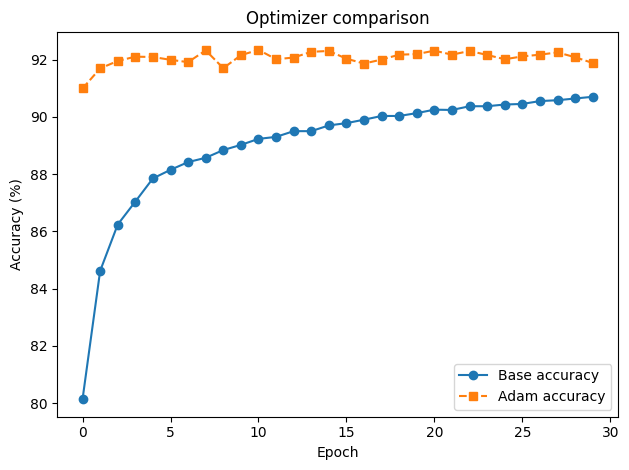

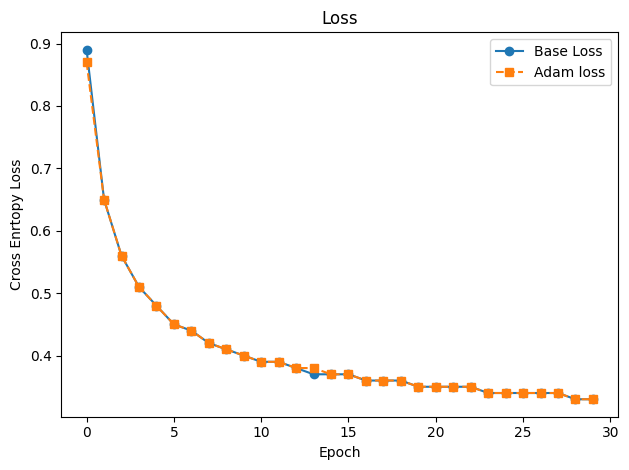

In [ ]:
fig = plt.figure()

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Optimizer comparison")
epochs = np.arange(len(base_training_acc))
plt.plot(epochs, base_val_acc, label="Base accuracy", linestyle="-", marker='o')
plt.plot(epochs, adam_val_acc, label="Adam accuracy", linestyle="--",marker='s')
plt.tight_layout()
plt.legend()
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Cross Enrtopy Loss")
plt.title("Loss")
plt.plot(epochs, base_val_loss, label="Base Loss",linestyle="-", marker='o')
plt.plot(epochs, l2_val_loss, label="Adam loss",linestyle="--", marker='s')
plt.tight_layout()
plt.legend()
plt.show()

### 5. Visualization of Learned Weights

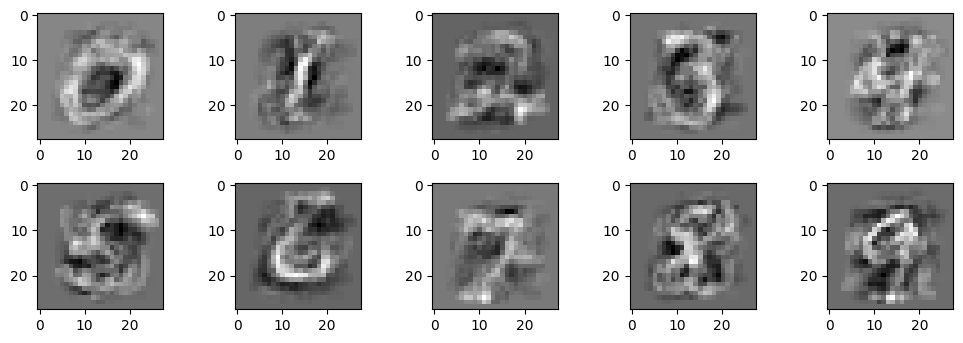

In [ ]:
# TODO: Plot each class’s weight vector as 28x28 image.
one_hot = torch.nn.functional.one_hot
LAMBDA = 1e3
def weight_interpret(train_X,train_y):
  train_X = train_X.view(train_X.size(0), -1)
  train_y = one_hot(train_y,num_classes=10).float()
  b = torch.mean(train_y,dim=0,keepdim=True)
  train_X_mean = torch.mean(train_X,dim=0,keepdim=True)
  X = train_X - train_X_mean
  theta = torch.mm(torch.mm(torch.inverse(torch.matmul(X.t(),X)+LAMBDA*torch.eye(784)),X.t()),(train_y-b))
  return theta,train_X_mean,b

train_examples = enumerate(train_loader)
batch_idx, (train_X, train_y) = next(train_examples)
theta, train_X_mean, b =weight_interpret(train_X,train_y)

fig = plt.figure(figsize=(10,5))
for i in range(10):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(theta[:,i].reshape(28,28), cmap='gray', interpolation='none')

# Part 2 — Take-Home (3%)

Extend your experiments and write a short (≈1 page) report.  
**Deadline:** One week after the lab.

### 1. Confusion Matrix

In [ ]:
model_conf =LogisticRegression().to(device)
y_pred, y_test = train(None, None,model_conf, None,1, 'yes',None)

epoch 1, loss 1.3418449206120522
nValidation set: Avg. loss: 0.8729, Accuracy: 8023/10000 (80%)

epoch 2, loss 0.7541767331340429
nValidation set: Avg. loss: 0.6501, Accuracy: 8460/10000 (85%)

epoch 3, loss 0.6125733287590543
nValidation set: Avg. loss: 0.5596, Accuracy: 8612/10000 (86%)

epoch 4, loss 0.5442042593151102
nValidation set: Avg. loss: 0.5095, Accuracy: 8701/10000 (87%)

epoch 5, loss 0.5029641663479378
nValidation set: Avg. loss: 0.4766, Accuracy: 8762/10000 (88%)

epoch 6, loss 0.47468207185835487
nValidation set: Avg. loss: 0.4534, Accuracy: 8804/10000 (88%)

epoch 7, loss 0.45377494131817536
nValidation set: Avg. loss: 0.4359, Accuracy: 8835/10000 (88%)

epoch 8, loss 0.43777106347901135
nValidation set: Avg. loss: 0.4219, Accuracy: 8856/10000 (89%)

epoch 9, loss 0.424796625857463
nValidation set: Avg. loss: 0.4106, Accuracy: 8880/10000 (89%)

epoch 10, loss 0.41412732226159565
nValidation set: Avg. loss: 0.4015, Accuracy: 8896/10000 (89%)

epoch 11, loss 0.405116656

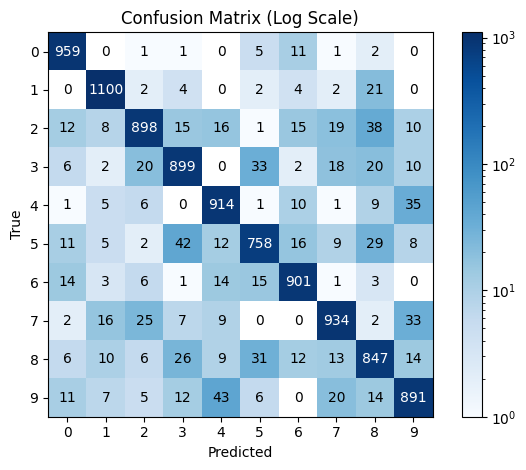

In [ ]:
# TODO: Compute confusion matrix on test set predictions.
%matplotlib inline
#reference = https://stackoverflow.com/questions/53351963/mnist-get-confusion-matrix
#used chat to improve visibilty https://chatgpt.com/share/68cf9e2a-c1c4-800b-b730-2b19e40f811f

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred,y_test=train(optim= None, regularization=None,model=model, l1_lambda=None, training_size = 1, confusion =None,flip=None)
confusion = confusion_matrix(y_test.numpy(), y_pred.numpy())

plt.imshow(confusion, interpolation='nearest', cmap="Blues", norm=plt.cm.colors.LogNorm())
plt.title("Confusion Matrix (Log Scale)")
plt.colorbar()

tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

plt.xlabel("Predicted")
plt.ylabel("True")

# Show numbers inside cells
thresh = confusion.max() / 2  # threshold for text color
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, format(confusion[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

### 2. Reduced Training Data

In [ ]:
# TODO: Train logistic regression with only 10%, 25%, 50% of train data.
# Plot validation accuracy vs dataset size.

model_010 = LogisticRegression().to(device)
num_epochs,training_acc_010,val_acc_010,training_loss_010,val_loss_010 = train(None,None,model_010,None,0.1)
#print(num_epochs,training_acc,val_acc,training_loss,val_loss)

epoch 1, loss 0.22058300563441519
nValidation set: Avg. loss: 1.9574, Accuracy: 3570/10000 (36%)

epoch 2, loss 0.18609766277205914
nValidation set: Avg. loss: 1.6622, Accuracy: 5614/10000 (56%)

epoch 3, loss 0.160540783801652
nValidation set: Avg. loss: 1.4535, Accuracy: 6510/10000 (65%)

epoch 4, loss 0.13977199655664546
nValidation set: Avg. loss: 1.2963, Accuracy: 6983/10000 (70%)

epoch 5, loss 0.12760386442589333
nValidation set: Avg. loss: 1.1783, Accuracy: 7341/10000 (73%)

epoch 6, loss 0.11557735171159515
nValidation set: Avg. loss: 1.0854, Accuracy: 7559/10000 (76%)

epoch 7, loss 0.10832723357793315
nValidation set: Avg. loss: 1.0126, Accuracy: 7754/10000 (78%)

epoch 8, loss 0.10157367472758379
nValidation set: Avg. loss: 0.9530, Accuracy: 7886/10000 (79%)

epoch 9, loss 0.09636871741555841
nValidation set: Avg. loss: 0.9039, Accuracy: 7959/10000 (80%)

epoch 10, loss 0.09136605994475772
nValidation set: Avg. loss: 0.8612, Accuracy: 8056/10000 (81%)

epoch 11, loss 0.0886

In [ ]:
model_025 = LogisticRegression().to(device)
num_epochs,training_acc_025,val_acc_025,training_loss_025,val_loss_025 = train(None,None,model_025,None,0.25)
#print(num_epochs,training_acc,val_acc,training_loss,val_loss)

epoch 1, loss 0.5102909864367121
nValidation set: Avg. loss: 1.6402, Accuracy: 5563/10000 (56%)

epoch 2, loss 0.35684107362156936
nValidation set: Avg. loss: 1.2265, Accuracy: 7307/10000 (73%)

epoch 3, loss 0.28055263998563335
nValidation set: Avg. loss: 1.0092, Accuracy: 7847/10000 (78%)

epoch 4, loss 0.23990813606535383
nValidation set: Avg. loss: 0.8788, Accuracy: 8142/10000 (81%)

epoch 5, loss 0.21292995674835752
nValidation set: Avg. loss: 0.7933, Accuracy: 8276/10000 (83%)

epoch 6, loss 0.19310748089304972
nValidation set: Avg. loss: 0.7306, Accuracy: 8404/10000 (84%)

epoch 7, loss 0.17736764118799467
nValidation set: Avg. loss: 0.6842, Accuracy: 8461/10000 (85%)

epoch 8, loss 0.17018321865354963
nValidation set: Avg. loss: 0.6473, Accuracy: 8536/10000 (85%)

epoch 9, loss 0.16255795041008678
nValidation set: Avg. loss: 0.6180, Accuracy: 8588/10000 (86%)

epoch 10, loss 0.1558784676329864
nValidation set: Avg. loss: 0.5939, Accuracy: 8612/10000 (86%)

epoch 11, loss 0.1510

In [ ]:
model_050 = LogisticRegression().to(device)
num_epochs,training_acc_050,val_acc_050,training_loss_050,val_loss_050 = train(None,None,model_050,None,0.5)
#print(num_epochs,training_acc,val_acc,training_loss,val_loss)

epoch 1, loss 0.8086786962226223
nValidation set: Avg. loss: 1.1839, Accuracy: 7281/10000 (73%)

epoch 2, loss 0.5068858340573128
nValidation set: Avg. loss: 0.8723, Accuracy: 7997/10000 (80%)

epoch 3, loss 0.4042651424627475
nValidation set: Avg. loss: 0.7323, Accuracy: 8308/10000 (83%)

epoch 4, loss 0.3488237790744323
nValidation set: Avg. loss: 0.6513, Accuracy: 8453/10000 (85%)

epoch 5, loss 0.3138540778166193
nValidation set: Avg. loss: 0.5982, Accuracy: 8553/10000 (86%)

epoch 6, loss 0.2908305159920012
nValidation set: Avg. loss: 0.5608, Accuracy: 8610/10000 (86%)

epoch 7, loss 0.27966280613104094
nValidation set: Avg. loss: 0.5327, Accuracy: 8664/10000 (87%)

epoch 8, loss 0.26486081418478885
nValidation set: Avg. loss: 0.5100, Accuracy: 8707/10000 (87%)

epoch 9, loss 0.2573316826692323
nValidation set: Avg. loss: 0.4918, Accuracy: 8743/10000 (87%)

epoch 10, loss 0.24750061603763218
nValidation set: Avg. loss: 0.4770, Accuracy: 8771/10000 (88%)

epoch 11, loss 0.236800438

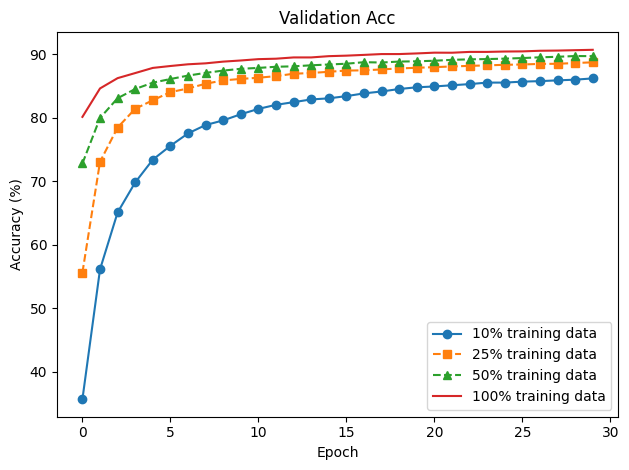

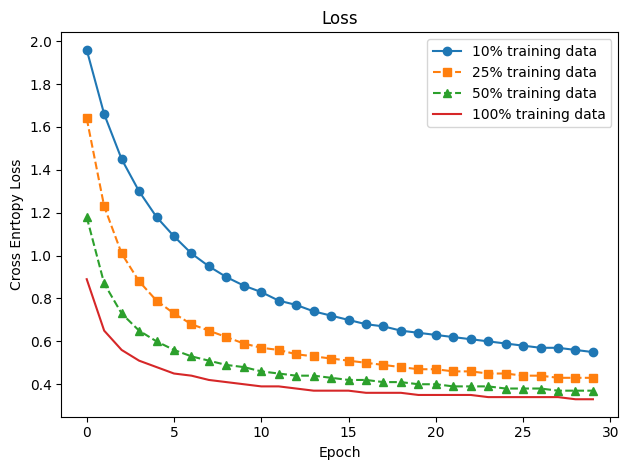

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Acc")
epochs = np.arange(len(base_training_acc))
plt.plot(epochs, val_acc_010, label="10% training data", linestyle="-", marker='o')
plt.plot(epochs, val_acc_025, label="25% training data", linestyle="--",marker='s')
plt.plot(epochs, val_acc_050, label="50% training data", linestyle="--",marker='^')
plt.plot(epochs, base_val_acc, label="100% training data", linestyle="-")
plt.tight_layout()
plt.legend()
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Cross Enrtopy Loss")
plt.title("Loss")
plt.plot(epochs, val_loss_010, label="10% training data", linestyle="-", marker='o')
plt.plot(epochs, val_loss_025, label="25% training data", linestyle="--",marker='s')
plt.plot(epochs, val_loss_050, label="50% training data", linestyle="--",marker='^')
plt.plot(epochs, base_val_loss, label="100% training data", linestyle="-")
plt.tight_layout()
plt.legend()
plt.show()

### 3. Noisy Labels

In [ ]:
# TODO: Randomly flip 10% of training labels, retrain, and measure accuracy drop.
flip_model = LogisticRegression().to(device)
num_epochs,training_acc_flip,val_acc_flip,training_loss_flip,val_loss_flip = train(None,None,flip_model,None,1,None,'flip')

epoch 1, loss 1.525351663684601
nValidation set: Avg. loss: 0.9407, Accuracy: 8154/10000 (82%)

epoch 2, loss 1.0512117801419913
nValidation set: Avg. loss: 0.7171, Accuracy: 8499/10000 (85%)

epoch 3, loss 0.955108826879955
nValidation set: Avg. loss: 0.6284, Accuracy: 8634/10000 (86%)

epoch 4, loss 0.9205846722473574
nValidation set: Avg. loss: 0.5818, Accuracy: 8711/10000 (87%)

epoch 5, loss 0.8965928755757754
nValidation set: Avg. loss: 0.5517, Accuracy: 8762/10000 (88%)

epoch 6, loss 0.8821048648156169
nValidation set: Avg. loss: 0.5310, Accuracy: 8828/10000 (88%)

epoch 7, loss 0.8702263126287924
nValidation set: Avg. loss: 0.5158, Accuracy: 8851/10000 (89%)

epoch 8, loss 0.8616517521536259
nValidation set: Avg. loss: 0.5045, Accuracy: 8870/10000 (89%)

epoch 9, loss 0.8516170441951898
nValidation set: Avg. loss: 0.4951, Accuracy: 8877/10000 (89%)

epoch 10, loss 0.847347843829933
nValidation set: Avg. loss: 0.4875, Accuracy: 8903/10000 (89%)

epoch 11, loss 0.843626155267896

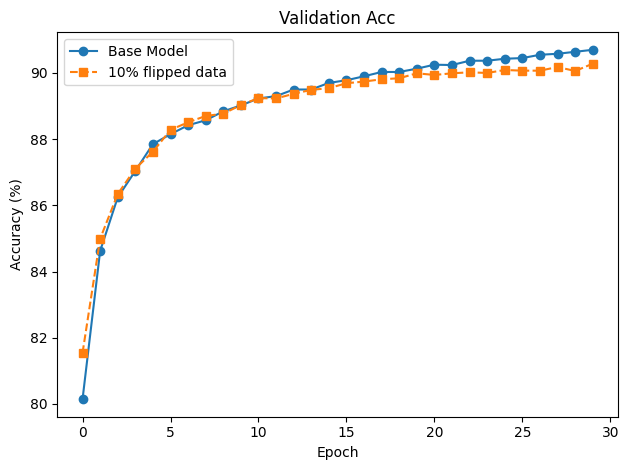

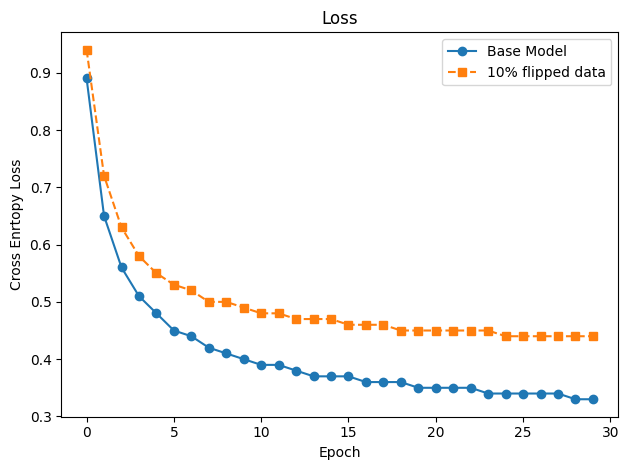

In [ ]:
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Acc")
epochs = np.arange(len(base_training_acc))
plt.plot(epochs, base_val_acc, label="Base Model", linestyle="-", marker='o')
plt.plot(epochs, val_acc_flip, label="10% flipped data", linestyle="--",marker='s')
plt.tight_layout()
plt.legend()
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Cross Enrtopy Loss")
plt.title("Loss")
plt.plot(epochs, base_val_loss, label="Base Model", linestyle="-", marker='o')
plt.plot(epochs, val_loss_flip, label="10% flipped data", linestyle="--",marker='s')
plt.tight_layout()
plt.legend()
plt.show()

### 4. Short Report

- Which regularization worked better (L1 vs L2)?  
- Which optimizer was more effective (SGD vs Adam)?  
- What does the confusion matrix reveal?  
- How does performance degrade with reduced or noisy data?  
- How did Gemini help (include sample prompts + modifications)?



*   L2 regularization performs better with greater validation, lower loss and higher test acc.
*   Adam Optimizaer works better than the SGD with validation acc constantly around 92% and test acc at 93%, the loss convergence is comparable.
*   Confusion matrix analysis, the most amount of confusions happen with the ground truth being 4 and model predicts 9, which is justified because of the resemblance , followed by 3 confused by 5,9 confused with 4 and 8 confused with 2.
* As expected , the lowest accuracy is for the 10% training data and the highest one is the one with 50% training data.



